# Eland Demo Notebook

<a target="_blank" href="https://colab.research.google.com/github/elastic/eland/blob/main/docs/sphinx/examples/demo_notebook.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we'll show you how to explore and analyze data in Elasticsearch using the familiar Pandas-compatible API.

## Requirements 🧰

For this example, you will need:

- Python 3.8 or later
- An Elastic deployment
  - We'll be using [Elastic Cloud](https://www.elastic.co/guide/en/cloud/current/ec-getting-started.html) for this example (available with a [free trial](https://cloud.elastic.co/registration))

### Create Elastic Cloud deployment

If you don't have an Elastic Cloud deployment, follow these steps to create one.

1. Go to https://cloud.elastic.co/registration and sign up for a free trial
2. Select **Create Deployment** and follow the instructions


## Install packages 📦

First we `pip install` and import the packages we need for this example.


In [1]:
# TODO switch to !pip install eland before merging
!pip install git+https://github.com/pquentin/eland.git@demo-notebook-colab

import os

import eland as ed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

from elasticsearch import Elasticsearch

# Import standard test settings for consistent results
from eland.conftest import *

  Cloning https://github.com/pquentin/eland.git (to revision demo-notebook-colab) to /tmp/pip-req-build-llaufivk
  Running command git clone --filter=blob:none --quiet https://github.com/pquentin/eland.git /tmp/pip-req-build-llaufivk
  Running command git checkout -b demo-notebook-colab --track origin/demo-notebook-colab
  Switched to a new branch 'demo-notebook-colab'
  branch 'demo-notebook-colab' set up to track 'origin/demo-notebook-colab'.
  Resolved https://github.com/pquentin/eland.git to commit a85c8debaf44833ea1e8eb0041cd654dc2029709
  Preparing metadata (setup.py) ... - done


## Initialize client 🔌

Next we input credentials with `getpass`. `getpass` is part of the Python standard library and is used to securely prompt for credentials.

In [2]:
from getpass import getpass

if os.environ.get("DOCS_BUILD"):
  # Building the docs relies on a local cluster
  es_kwargs = {"hosts": "http://localhost:9200"}
else:
  cloud_id = getpass("Elastic Cloud ID: ")
  username = getpass("Elastic username: ")
  password = getpass("Elastic password: ")
  es_kwargs = {
      "cloud_id": cloud_id,
      "basic_auth": (username, password)
  }

es = Elasticsearch(**es_kwargs)
es_info = es.info()
print(f"Connected to cluster named '{es_info['cluster_name']}' (version: {es_info['version']['number']})")


Connected to cluster named 'docker-cluster' (version: 8.10.1)


## Load and process documents 📄

Time to load some data! We'll be using the Eland test data, which is a fake flights dataset.

In [3]:
import tempfile

from eland import pandas_to_es
from eland import dataload

if not os.environ.get("DOCS_BUILD"):
  with tempfile.TemporaryDirectory() as tmpdir:
    r = requests.get("https://github.com/elastic/eland/raw/main/tests/flights.json.gz")
    path = os.path.join(tmpdir, "flights.json.gz")
    with open(path, "wb") as f:
      f.write(r.content)

    df = pd.read_json(path, lines=True)
    pandas_to_es(df, es, dataload.FLIGHTS_INDEX_NAME, dataload.FLIGHTS_MAPPING)

## Compare Eland DataFrame vs pandas DataFrame

Create an eland.DataFrame from a `flights` index

In [4]:
ed_flights = ed.DataFrame(es, 'flights')

In [5]:
type(ed_flights)

eland.dataframe.DataFrame

Compare to pandas DataFrame (created from the same data)

In [6]:
pd_flights = ed.eland_to_pandas(ed_flights)

In [7]:
type(pd_flights)

pandas.core.frame.DataFrame

## Attributes and underlying data

### DataFrame.columns

In [8]:
pd_flights.columns

Index(['AvgTicketPrice', 'Cancelled', 'Carrier', 'Dest', 'DestAirportID', 'DestCityName',
       'DestCountry', 'DestLocation', 'DestRegion', 'DestWeather', 'DistanceKilometers',
       'DistanceMiles', 'FlightDelay', 'FlightDelayMin', 'FlightDelayType', 'FlightNum',
       'FlightTimeHour', 'FlightTimeMin', 'Origin', 'OriginAirportID', 'OriginCityName',
       'OriginCountry', 'OriginLocation', 'OriginRegion', 'OriginWeather', 'dayOfWeek',
       'timestamp'],
      dtype='object')

In [9]:
ed_flights.columns

Index(['AvgTicketPrice', 'Cancelled', 'Carrier', 'Dest', 'DestAirportID', 'DestCityName',
       'DestCountry', 'DestLocation', 'DestRegion', 'DestWeather', 'DistanceKilometers',
       'DistanceMiles', 'FlightDelay', 'FlightDelayMin', 'FlightDelayType', 'FlightNum',
       'FlightTimeHour', 'FlightTimeMin', 'Origin', 'OriginAirportID', 'OriginCityName',
       'OriginCountry', 'OriginLocation', 'OriginRegion', 'OriginWeather', 'dayOfWeek',
       'timestamp'],
      dtype='object')

### DataFrame.dtypes

In [10]:
pd_flights.dtypes

AvgTicketPrice           float64
Cancelled                   bool
Carrier                   object
Dest                      object
DestAirportID             object
                       ...      
OriginLocation            object
OriginRegion              object
OriginWeather             object
dayOfWeek                  int64
timestamp         datetime64[ns]
Length: 27, dtype: object

In [11]:
ed_flights.dtypes

AvgTicketPrice           float64
Cancelled                   bool
Carrier                   object
Dest                      object
DestAirportID             object
                       ...      
OriginLocation            object
OriginRegion              object
OriginWeather             object
dayOfWeek                  int64
timestamp         datetime64[ns]
Length: 27, dtype: object

### DataFrame.select_dtypes

In [12]:
pd_flights.select_dtypes(include=np.number)

,AvgTicketPrice,DistanceKilometers,...,FlightTimeMin,dayOfWeek
0,841.265642,16492.326654,...,1030.770416,0
1,882.982662,8823.400140,...,464.389481,0
2,190.636904,0.000000,...,0.000000,0
3,181.694216,555.737767,...,222.749059,0
4,730.041778,13358.244200,...,785.779071,0
...,...,...,...,...,...
13054,1080.446279,8058.581753,...,402.929088,6
13055,646.612941,7088.598322,...,644.418029,6
13056,997.751876,10920.652972,...,937.540811,6
13057,1102.814465,18748.859647,...,1697.404971,6


In [13]:
ed_flights.select_dtypes(include=np.number)

,AvgTicketPrice,DistanceKilometers,...,FlightTimeMin,dayOfWeek
0,841.265642,16492.326654,...,1030.770416,0
1,882.982662,8823.400140,...,464.389481,0
2,190.636904,0.000000,...,0.000000,0
3,181.694216,555.737767,...,222.749059,0
4,730.041778,13358.244200,...,785.779071,0
...,...,...,...,...,...
13054,1080.446279,8058.581753,...,402.929088,6
13055,646.612941,7088.598322,...,644.418029,6
13056,997.751876,10920.652972,...,937.540811,6
13057,1102.814465,18748.859647,...,1697.404971,6


### DataFrame.empty

In [14]:
pd_flights.empty

False

In [15]:
ed_flights.empty

False

### DataFrame.shape

In [16]:
pd_flights.shape

(13059, 27)

In [17]:
ed_flights.shape

(13059, 27)

### DataFrame.index

Note, `eland.DataFrame.index` does not mirror `pandas.DataFrame.index`.

In [18]:
pd_flights.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '13049', '13050', '13051', '13052', '13053', '13054', '13055', '13056', '13057', '13058'],
      dtype='object', length=13059)

In [19]:
# NBVAL_IGNORE_OUTPUT
ed_flights.index

In [20]:
ed_flights.index.es_index_field

'_id'

### DataFrame.values

Note, `eland.DataFrame.values` is not supported.

In [21]:
pd_flights.values

array([[841.2656419677076, False, 'Kibana Airlines', ..., 'Sunny', 0,
        Timestamp('2018-01-01 00:00:00')],
       [882.9826615595518, False, 'Logstash Airways', ..., 'Clear', 0,
        Timestamp('2018-01-01 18:27:00')],
       [190.6369038508356, False, 'Logstash Airways', ..., 'Rain', 0,
        Timestamp('2018-01-01 17:11:14')],
       ...,
       [997.7518761454494, False, 'Logstash Airways', ..., 'Sunny', 6,
        Timestamp('2018-02-11 04:09:27')],
       [1102.8144645388556, False, 'JetBeats', ..., 'Hail', 6,
        Timestamp('2018-02-11 08:28:21')],
       [858.1443369038839, False, 'JetBeats', ..., 'Rain', 6,
        Timestamp('2018-02-11 14:54:34')]], dtype=object)

In [22]:
try:
    ed_flights.values
except AttributeError as e:
    print(e)

This method would scan/scroll the entire Elasticsearch index(s) into memory. If this is explicitly required, and there is sufficient memory, call `ed.eland_to_pandas(ed_df).values`


## Indexing, iteration

### DataFrame.head

In [23]:
pd_flights.head()

,AvgTicketPrice,Cancelled,...,dayOfWeek,timestamp
0,841.265642,False,...,0,2018-01-01 00:00:00
1,882.982662,False,...,0,2018-01-01 18:27:00
2,190.636904,False,...,0,2018-01-01 17:11:14
3,181.694216,True,...,0,2018-01-01 10:33:28
4,730.041778,False,...,0,2018-01-01 05:13:00


In [24]:
ed_flights.head()

,AvgTicketPrice,Cancelled,...,dayOfWeek,timestamp
0,841.265642,False,...,0,2018-01-01 00:00:00
1,882.982662,False,...,0,2018-01-01 18:27:00
2,190.636904,False,...,0,2018-01-01 17:11:14
3,181.694216,True,...,0,2018-01-01 10:33:28
4,730.041778,False,...,0,2018-01-01 05:13:00


### DataFrame.tail

In [25]:
pd_flights.tail()

,AvgTicketPrice,Cancelled,...,dayOfWeek,timestamp
13054,1080.446279,False,...,6,2018-02-11 20:42:25
13055,646.612941,False,...,6,2018-02-11 01:41:57
13056,997.751876,False,...,6,2018-02-11 04:09:27
13057,1102.814465,False,...,6,2018-02-11 08:28:21
13058,858.144337,False,...,6,2018-02-11 14:54:34


In [26]:
ed_flights.tail()

,AvgTicketPrice,Cancelled,...,dayOfWeek,timestamp
13054,1080.446279,False,...,6,2018-02-11 20:42:25
13055,646.612941,False,...,6,2018-02-11 01:41:57
13056,997.751876,False,...,6,2018-02-11 04:09:27
13057,1102.814465,False,...,6,2018-02-11 08:28:21
13058,858.144337,False,...,6,2018-02-11 14:54:34


### DataFrame.keys

In [27]:
pd_flights.keys()

Index(['AvgTicketPrice', 'Cancelled', 'Carrier', 'Dest', 'DestAirportID', 'DestCityName',
       'DestCountry', 'DestLocation', 'DestRegion', 'DestWeather', 'DistanceKilometers',
       'DistanceMiles', 'FlightDelay', 'FlightDelayMin', 'FlightDelayType', 'FlightNum',
       'FlightTimeHour', 'FlightTimeMin', 'Origin', 'OriginAirportID', 'OriginCityName',
       'OriginCountry', 'OriginLocation', 'OriginRegion', 'OriginWeather', 'dayOfWeek',
       'timestamp'],
      dtype='object')

In [28]:
ed_flights.keys()

Index(['AvgTicketPrice', 'Cancelled', 'Carrier', 'Dest', 'DestAirportID', 'DestCityName',
       'DestCountry', 'DestLocation', 'DestRegion', 'DestWeather', 'DistanceKilometers',
       'DistanceMiles', 'FlightDelay', 'FlightDelayMin', 'FlightDelayType', 'FlightNum',
       'FlightTimeHour', 'FlightTimeMin', 'Origin', 'OriginAirportID', 'OriginCityName',
       'OriginCountry', 'OriginLocation', 'OriginRegion', 'OriginWeather', 'dayOfWeek',
       'timestamp'],
      dtype='object')

### DataFrame.get

In [29]:
pd_flights.get('Carrier')

0         Kibana Airlines
1        Logstash Airways
2        Logstash Airways
3         Kibana Airlines
4         Kibana Airlines
               ...       
13054    Logstash Airways
13055    Logstash Airways
13056    Logstash Airways
13057            JetBeats
13058            JetBeats
Name: Carrier, Length: 13059, dtype: object

In [30]:
ed_flights.get('Carrier')

0         Kibana Airlines
1        Logstash Airways
2        Logstash Airways
3         Kibana Airlines
4         Kibana Airlines
               ...       
13054    Logstash Airways
13055    Logstash Airways
13056    Logstash Airways
13057            JetBeats
13058            JetBeats
Name: Carrier, Length: 13059, dtype: object

In [31]:
pd_flights.get(['Carrier', 'Origin'])

,Carrier,Origin
0,Kibana Airlines,Frankfurt am Main Airport
1,Logstash Airways,Cape Town International Airport
2,Logstash Airways,Venice Marco Polo Airport
3,Kibana Airlines,Naples International Airport
4,Kibana Airlines,Licenciado Benito Juarez International Airport
...,...,...
13054,Logstash Airways,Pisa International Airport
13055,Logstash Airways,Winnipeg / James Armstrong Richardson Internat...
13056,Logstash Airways,Licenciado Benito Juarez International Airport
13057,JetBeats,Itami Airport


List input not currently supported by `eland.DataFrame.get`

In [32]:
try:
    ed_flights.get(['Carrier', 'Origin'])
except TypeError as e:
    print(e)

unhashable type: 'list'


### DataFrame.query

In [33]:
pd_flights.query('Carrier == "Kibana Airlines" & AvgTicketPrice > 900.0 & Cancelled == True')

,AvgTicketPrice,Cancelled,...,dayOfWeek,timestamp
8,960.869736,True,...,0,2018-01-01 12:09:35
26,975.812632,True,...,0,2018-01-01 15:38:32
311,946.358410,True,...,0,2018-01-01 11:51:12
651,975.383864,True,...,2,2018-01-03 21:13:17
950,907.836523,True,...,2,2018-01-03 05:14:51
...,...,...,...,...,...
12820,909.973606,True,...,5,2018-02-10 05:11:35
12906,983.429244,True,...,6,2018-02-11 06:19:58
12918,1136.678150,True,...,6,2018-02-11 16:03:10
12919,1105.211803,True,...,6,2018-02-11 05:36:05


`eland.DataFrame.query` requires qualifier on bool i.e.

`ed_flights.query('Carrier == "Kibana Airlines" & AvgTicketPrice > 900.0 & Cancelled')` fails

In [34]:
try:
  ed_flights.query('Carrier == "Kibana Airlines" & AvgTicketPrice > 900.0 & Cancelled == True')
except Exception as e:
  print(f"query() failed as expected: {repr(e)}.")

#### Boolean indexing query

In [35]:
pd_flights[(pd_flights.Carrier=="Kibana Airlines") &
           (pd_flights.AvgTicketPrice > 900.0) &
           (pd_flights.Cancelled == True)]

,AvgTicketPrice,Cancelled,...,dayOfWeek,timestamp
8,960.869736,True,...,0,2018-01-01 12:09:35
26,975.812632,True,...,0,2018-01-01 15:38:32
311,946.358410,True,...,0,2018-01-01 11:51:12
651,975.383864,True,...,2,2018-01-03 21:13:17
950,907.836523,True,...,2,2018-01-03 05:14:51
...,...,...,...,...,...
12820,909.973606,True,...,5,2018-02-10 05:11:35
12906,983.429244,True,...,6,2018-02-11 06:19:58
12918,1136.678150,True,...,6,2018-02-11 16:03:10
12919,1105.211803,True,...,6,2018-02-11 05:36:05


In [36]:
ed_flights[(ed_flights.Carrier=="Kibana Airlines") &
           (ed_flights.AvgTicketPrice > 900.0) &
           (ed_flights.Cancelled == True)]

,AvgTicketPrice,Cancelled,...,dayOfWeek,timestamp
8,960.869736,True,...,0,2018-01-01 12:09:35
26,975.812632,True,...,0,2018-01-01 15:38:32
311,946.358410,True,...,0,2018-01-01 11:51:12
651,975.383864,True,...,2,2018-01-03 21:13:17
950,907.836523,True,...,2,2018-01-03 05:14:51
...,...,...,...,...,...
12820,909.973606,True,...,5,2018-02-10 05:11:35
12906,983.429244,True,...,6,2018-02-11 06:19:58
12918,1136.678150,True,...,6,2018-02-11 16:03:10
12919,1105.211803,True,...,6,2018-02-11 05:36:05


## Function application, GroupBy & window

### DataFrame.aggs

In [37]:
pd_flights[['DistanceKilometers', 'AvgTicketPrice']].aggregate(['sum', 'min', 'std'])

,DistanceKilometers,AvgTicketPrice
sum,9.261629e+07,8.204365e+06
min,0.000000e+00,1.000205e+02
std,4.578438e+03,2.663969e+02


`eland.DataFrame.aggregate` currently only supported numeric columns

In [38]:
ed_flights[['DistanceKilometers', 'AvgTicketPrice']].aggregate(['sum', 'min', 'std'])

,DistanceKilometers,AvgTicketPrice
sum,9.261629e+07,8.204365e+06
min,0.000000e+00,1.000205e+02
std,4.578614e+03,2.664071e+02


## Computations / descriptive stats

### DataFrame.count

In [39]:
pd_flights.count()

AvgTicketPrice    13059
Cancelled         13059
Carrier           13059
Dest              13059
DestAirportID     13059
                  ...  
OriginLocation    13059
OriginRegion      13059
OriginWeather     13059
dayOfWeek         13059
timestamp         13059
Length: 27, dtype: int64

In [40]:
ed_flights.count()

AvgTicketPrice    13059
Cancelled         13059
Carrier           13059
Dest              13059
DestAirportID     13059
                  ...  
OriginLocation    13059
OriginRegion      13059
OriginWeather     13059
dayOfWeek         13059
timestamp         13059
Length: 27, dtype: int64

### DataFrame.describe

In [41]:
pd_flights.describe()

,AvgTicketPrice,DistanceKilometers,...,FlightTimeMin,dayOfWeek
count,13059.000000,13059.000000,...,13059.000000,13059.000000
mean,628.253689,7092.142455,...,511.127842,2.835975
std,266.396861,4578.438497,...,334.753952,1.939439
min,100.020528,0.000000,...,0.000000,0.000000
25%,409.893816,2459.705673,...,252.333192,1.000000
50%,640.556668,7610.330866,...,503.045170,3.000000
75%,842.185470,9736.637600,...,720.416036,4.000000
max,1199.729053,19881.482315,...,1902.902032,6.000000


Values returned from `eland.DataFrame.describe` may vary due to results of Elasticsearch aggregations.

In [42]:
# NBVAL_IGNORE_OUTPUT
ed_flights.describe()

,AvgTicketPrice,Cancelled,...,FlightTimeMin,dayOfWeek
count,13059.000000,13059.000000,...,13059.000000,13059.000000
mean,628.253689,0.128494,...,511.127842,2.835975
std,266.407061,0.334664,...,334.766770,1.939513
min,100.020531,0.000000,...,0.000000,0.000000
25%,411.154491,0.000000,...,250.428538,1.058527
50%,639.433214,0.000000,...,502.777975,2.935777
75%,842.336195,0.000000,...,721.351220,4.427843
max,1199.729004,1.000000,...,1902.901978,6.000000


### DataFrame.info

In [43]:
pd_flights.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13059 entries, 0 to 13058
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AvgTicketPrice      13059 non-null  float64       
 1   Cancelled           13059 non-null  bool          
 2   Carrier             13059 non-null  object        
 3   Dest                13059 non-null  object        
 4   DestAirportID       13059 non-null  object        
 5   DestCityName        13059 non-null  object        
 6   DestCountry         13059 non-null  object        
 7   DestLocation        13059 non-null  object        
 8   DestRegion          13059 non-null  object        
 9   DestWeather         13059 non-null  object        
 10  DistanceKilometers  13059 non-null  float64       
 11  DistanceMiles       13059 non-null  float64       
 12  FlightDelay         13059 non-null  bool          
 13  FlightDelayMin      13059 non-null  int64         


In [44]:
ed_flights.info()

<class 'eland.dataframe.DataFrame'>
Index: 13059 entries, 0 to 13058
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AvgTicketPrice      13059 non-null  float64       
 1   Cancelled           13059 non-null  bool          
 2   Carrier             13059 non-null  object        
 3   Dest                13059 non-null  object        
 4   DestAirportID       13059 non-null  object        
 5   DestCityName        13059 non-null  object        
 6   DestCountry         13059 non-null  object        
 7   DestLocation        13059 non-null  object        
 8   DestRegion          13059 non-null  object        
 9   DestWeather         13059 non-null  object        
 10  DistanceKilometers  13059 non-null  float64       
 11  DistanceMiles       13059 non-null  float64       
 12  FlightDelay         13059 non-null  bool          
 13  FlightDelayMin      13059 non-null  int64         
 1

### DataFrame.max, DataFrame.min, DataFrame.mean, DataFrame.sum

#### max

In [45]:
pd_flights.max(numeric_only=True)

AvgTicketPrice         1199.729053
Cancelled                     True
DistanceKilometers    19881.482315
DistanceMiles         12353.780369
FlightDelay                   True
FlightDelayMin                 360
FlightTimeHour           31.715034
FlightTimeMin          1902.902032
dayOfWeek                        6
dtype: object

`eland.DataFrame.max,min,mean,sum` only aggregate numeric columns

In [46]:
ed_flights.max(numeric_only=True)

AvgTicketPrice         1199.729004
Cancelled                 1.000000
DistanceKilometers    19881.482422
DistanceMiles         12353.780273
FlightDelay               1.000000
FlightDelayMin          360.000000
FlightTimeHour           31.715034
FlightTimeMin          1902.901978
dayOfWeek                 6.000000
dtype: float64

#### min

In [47]:
pd_flights.min(numeric_only=True)

AvgTicketPrice        100.020528
Cancelled                  False
DistanceKilometers           0.0
DistanceMiles                0.0
FlightDelay                False
FlightDelayMin                 0
FlightTimeHour               0.0
FlightTimeMin                0.0
dayOfWeek                      0
dtype: object

In [48]:
ed_flights.min(numeric_only=True)

AvgTicketPrice        100.020531
Cancelled               0.000000
DistanceKilometers      0.000000
DistanceMiles           0.000000
FlightDelay             0.000000
FlightDelayMin          0.000000
FlightTimeHour          0.000000
FlightTimeMin           0.000000
dayOfWeek               0.000000
dtype: float64

#### mean

In [49]:
pd_flights.mean(numeric_only=True)

AvgTicketPrice         628.253689
Cancelled                0.128494
DistanceKilometers    7092.142455
DistanceMiles         4406.853013
FlightDelay              0.251168
FlightDelayMin          47.335171
FlightTimeHour           8.518797
FlightTimeMin          511.127842
dayOfWeek                2.835975
dtype: float64

In [50]:
ed_flights.mean(numeric_only=True)

AvgTicketPrice         628.253689
Cancelled                0.128494
DistanceKilometers    7092.142457
DistanceMiles         4406.853010
FlightDelay              0.251168
FlightDelayMin          47.335171
FlightTimeHour           8.518797
FlightTimeMin          511.127842
dayOfWeek                2.835975
dtype: float64

#### sum

In [51]:
pd_flights.sum(numeric_only=True)

AvgTicketPrice        8.204365e+06
Cancelled             1.678000e+03
DistanceKilometers    9.261629e+07
DistanceMiles         5.754909e+07
FlightDelay           3.280000e+03
FlightDelayMin        6.181500e+05
FlightTimeHour        1.112470e+05
FlightTimeMin         6.674818e+06
dayOfWeek             3.703500e+04
dtype: float64

In [52]:
ed_flights.sum(numeric_only=True)

AvgTicketPrice        8.204365e+06
Cancelled             1.678000e+03
DistanceKilometers    9.261629e+07
DistanceMiles         5.754909e+07
FlightDelay           3.280000e+03
FlightDelayMin        6.181500e+05
FlightTimeHour        1.112470e+05
FlightTimeMin         6.674818e+06
dayOfWeek             3.703500e+04
dtype: float64

### DataFrame.nunique

In [53]:
pd_flights[['Carrier', 'Origin', 'Dest']].nunique()

Carrier      4
Origin     156
Dest       156
dtype: int64

In [54]:
ed_flights[['Carrier', 'Origin', 'Dest']].nunique()

Carrier      4
Origin     156
Dest       156
dtype: int64

### DataFrame.drop

In [55]:
pd_flights.drop(columns=['AvgTicketPrice',
                         'Cancelled',
                         'DestLocation',
                         'Dest',
                         'DestAirportID',
                         'DestCityName',
                         'DestCountry'])

,Carrier,DestRegion,...,dayOfWeek,timestamp
0,Kibana Airlines,SE-BD,...,0,2018-01-01 00:00:00
1,Logstash Airways,IT-34,...,0,2018-01-01 18:27:00
2,Logstash Airways,IT-34,...,0,2018-01-01 17:11:14
3,Kibana Airlines,IT-34,...,0,2018-01-01 10:33:28
4,Kibana Airlines,SE-BD,...,0,2018-01-01 05:13:00
...,...,...,...,...,...
13054,Logstash Airways,SE-BD,...,6,2018-02-11 20:42:25
13055,Logstash Airways,CH-ZH,...,6,2018-02-11 01:41:57
13056,Logstash Airways,RU-AMU,...,6,2018-02-11 04:09:27
13057,JetBeats,SE-BD,...,6,2018-02-11 08:28:21


In [56]:
ed_flights.drop(columns=['AvgTicketPrice',
                         'Cancelled',
                         'DestLocation',
                         'Dest',
                         'DestAirportID',
                         'DestCityName',
                         'DestCountry'])

,Carrier,DestRegion,...,dayOfWeek,timestamp
0,Kibana Airlines,SE-BD,...,0,2018-01-01 00:00:00
1,Logstash Airways,IT-34,...,0,2018-01-01 18:27:00
2,Logstash Airways,IT-34,...,0,2018-01-01 17:11:14
3,Kibana Airlines,IT-34,...,0,2018-01-01 10:33:28
4,Kibana Airlines,SE-BD,...,0,2018-01-01 05:13:00
...,...,...,...,...,...
13054,Logstash Airways,SE-BD,...,6,2018-02-11 20:42:25
13055,Logstash Airways,CH-ZH,...,6,2018-02-11 01:41:57
13056,Logstash Airways,RU-AMU,...,6,2018-02-11 04:09:27
13057,JetBeats,SE-BD,...,6,2018-02-11 08:28:21


### Plotting

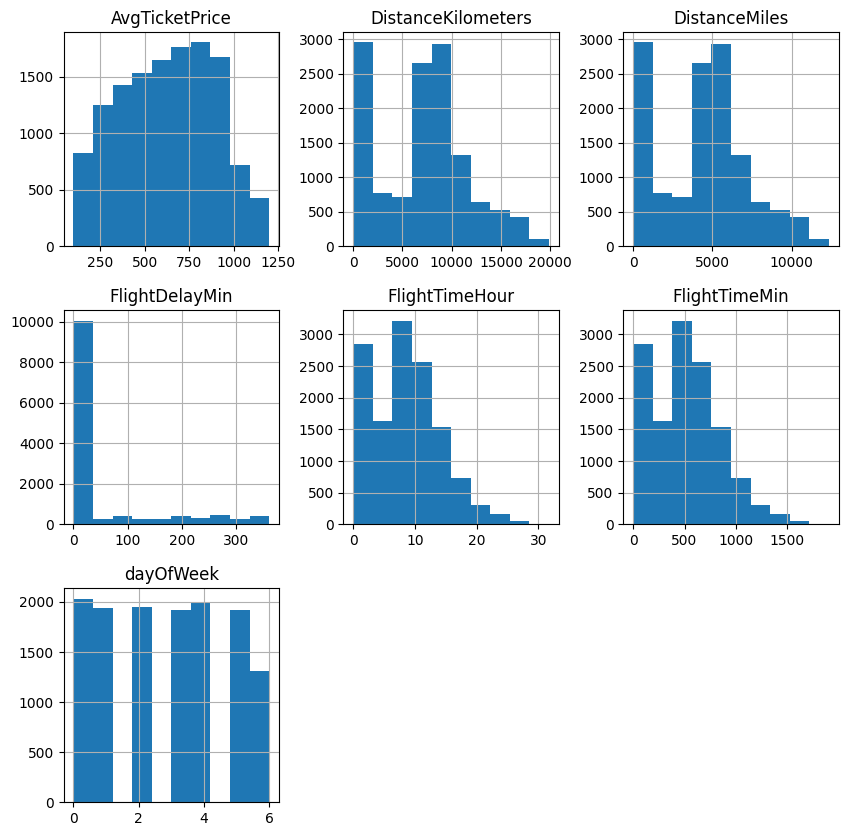

In [57]:
pd_flights.select_dtypes(include=np.number).hist(figsize=[10,10])
plt.show()

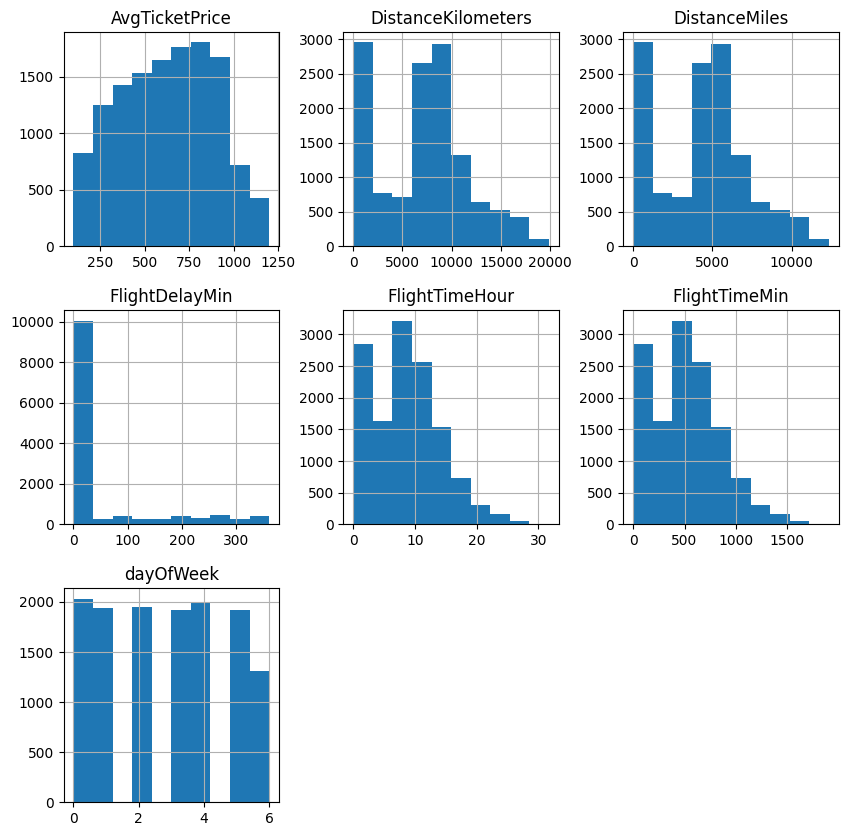

In [58]:
ed_flights.select_dtypes(include=np.number).hist(figsize=[10,10])
plt.show()

### Elasticsearch utilities

In [59]:
ed_flights2 = ed_flights[(ed_flights.OriginAirportID == 'AMS') & (ed_flights.FlightDelayMin > 60)]
ed_flights2 = ed_flights2[['timestamp', 'OriginAirportID', 'DestAirportID', 'FlightDelayMin']]
ed_flights2 = ed_flights2.tail()

In [60]:
print(ed_flights2.es_info())

es_index_pattern: flights
Index:
 es_index_field: _id
 is_source_field: False
Mappings:
 capabilities:
                   es_field_name  is_source es_dtype                  es_date_format        pd_dtype  is_searchable  is_aggregatable  is_scripted aggregatable_es_field_name
timestamp              timestamp       True     date  strict_date_hour_minute_second  datetime64[ns]           True             True        False                  timestamp
OriginAirportID  OriginAirportID       True  keyword                            None          object           True             True        False            OriginAirportID
DestAirportID      DestAirportID       True  keyword                            None          object           True             True        False              DestAirportID
FlightDelayMin    FlightDelayMin       True  integer                            None           int64           True             True        False             FlightDelayMin
Operations:
 tasks: [('boolean_f